Objective
Analyze how market sentiment (Fear/Greed) relates to trader behavior and performance on Hyperliquid. Your goal is to uncover patterns that could inform smarter trading strategies.


In [2]:

import pandas as pd
import numpy as np

#Load Data Set

fear_greed = pd.read_csv(r"C:\Users\Monu\OneDrive\Apps\Desktop\fear_greed_index.csv")
hist_data = pd.read_csv(r"C:\Users\Monu\OneDrive\Apps\Desktop\historical_data.csv")

print(fear_greed)
print(hist_data)

print(fear_greed.info())
print(hist_data.info())



       timestamp  value classification        date
0     1517463000     30           Fear  2018-02-01
1     1517549400     15   Extreme Fear  2018-02-02
2     1517635800     40           Fear  2018-02-03
3     1517722200     24   Extreme Fear  2018-02-04
4     1517808600     11   Extreme Fear  2018-02-05
...          ...    ...            ...         ...
2639  1745818200     54        Neutral  2025-04-28
2640  1745904600     60          Greed  2025-04-29
2641  1745991000     56          Greed  2025-04-30
2642  1746077400     53        Neutral  2025-05-01
2643  1746163800     67          Greed  2025-05-02

[2644 rows x 4 columns]
                                           Account      Coin  Execution Price  \
0       0xae5eacaf9c6b9111fd53034a602c192a04e082ed      @107           7.9769   
1       0xae5eacaf9c6b9111fd53034a602c192a04e082ed      @107           7.9800   
2       0xae5eacaf9c6b9111fd53034a602c192a04e082ed      @107           7.9855   
3       0xae5eacaf9c6b9111fd53034a602c1

In [3]:
# Check for missing values and duplicates
def data_summary(fear_greed, name):
    print(f"--- {name} ---")
    print("Shape:", fear_greed.shape)
    print("\nMissing values:\n", fear_greed.isna().sum())
    print("\nDuplicates:", fear_greed.duplicated().sum())

data_summary(fear_greed, "Fear & Greed Index")
data_summary(hist_data, "Historical Data")

--- Fear & Greed Index ---
Shape: (2644, 4)

Missing values:
 timestamp         0
value             0
classification    0
date              0
dtype: int64

Duplicates: 0
--- Historical Data ---
Shape: (211224, 16)

Missing values:
 Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64

Duplicates: 0


In [13]:
# 1. Clean up column names for both DataFrames (removes spaces & makes lowercase)
fear_greed.columns = fear_greed.columns.str.strip().str.lower()
hist_data.columns = hist_data.columns.str.strip().str.lower()

# 2. Convert fear_greed date
# If it's not 'date', it might be 'timestamp'. This 'fillna' trick checks both.
fg_col = 'date' if 'date' in fear_greed.columns else 'timestamp'
fear_greed["date"] = pd.to_datetime(fear_greed[fg_col]).dt.date

# 3. Convert hist_data time
# We use the 'timestamp' column you discovered earlier
hist_data["time"] = pd.to_datetime(hist_data["timestamp"], unit="ms")
hist_data["date"] = hist_data["time"].dt.date

# 4. Verify the result
print("Fear Greed Head:\n", fear_greed[['date']].head(2))
print("\nHist Data Head:\n", hist_data[['date']].head(2))

Fear Greed Head:
          date
0  2018-02-01
1  2018-02-02

Hist Data Head:
          date
0  2024-10-27
1  2024-10-27


In [16]:
hist_data = hist_data.merge(
    fear_greed,
    on="date",
    how="left"
)

print(f"Matched rows: {hist_data['value'].notna().sum()}")

Matched rows: 184263


In [25]:
# Create key metrics
hist_data["abs_size"] = hist_data["size usd"].abs()
hist_data["is_win"] = hist_data["closed pnl"] > 0
hist_data["is_long"] = hist_data["side"].str.upper() == "BUY"

print(hist_data[["size usd", "abs_size", "is_win"]].head())

   size usd  abs_size  is_win
0   7872.16   7872.16   False
1    127.68    127.68   False
2   1150.63   1150.63   False
3   1142.04   1142.04   False
4     69.75     69.75   False


In [26]:
# Daily metrics per trader
daily_trader = hist_data.groupby(
    ["date", "coin", "classification"]  
).agg(
    daily_pnl=("closed pnl", "sum"),
    trades_count=("closed pnl", "count"),
    win_rate=("is_win", "mean"),
    avg_trade_size=("abs_size", "mean"),
    long_ratio=("is_long", "mean")
).reset_index()

# Convert win_rate and long_ratio to percentages for easier reading
daily_trader["win_rate"] *= 100
daily_trader["long_ratio"] *= 100

print(daily_trader.head())

         date  coin classification   daily_pnl  trades_count   win_rate  \
0  2023-03-28   ETH          Greed    0.000000             3   0.000000   
1  2023-11-14  AAVE          Greed  114.203460            11  45.454545   
2  2023-11-14   ARB          Greed  143.945602            16  37.500000   
3  2023-11-14  BLUR          Greed  126.443496             6  50.000000   
4  2023-11-14   BTC          Greed  530.655361           227  29.515419   

   avg_trade_size  long_ratio  
0      159.000000  100.000000  
1     9263.628182   54.545455  
2     6262.348750   62.500000  
3     8354.898333   50.000000  
4    20504.371057   41.850220  


Part B Analysis

In [27]:
#  Does performance differ between Fear vs Greed?
performance_by_sentiment = daily_trader.groupby("classification").agg(
    avg_pnl=("daily_pnl", "mean"),
    median_pnl=("daily_pnl", "median"),
    avg_win_rate=("win_rate", "mean"),
    pnl_volatility=("daily_pnl", "std"),
    total_trades=("trades_count", "sum")
).sort_values("avg_pnl", ascending=False)

print(performance_by_sentiment)

                     avg_pnl  median_pnl  avg_win_rate  pnl_volatility  \
classification                                                           
Fear            43506.007731  292.761316     40.157282   222873.055973   
Greed           22462.088277   83.561283     36.361229   217238.945429   
Extreme Greed    2457.854052  442.627387     58.704080     6051.576859   
Neutral          2009.397191    0.000000     20.203737    17574.769891   

                total_trades  
classification                
Fear                  133871  
Greed                  36289  
Extreme Greed           6962  
Neutral                 7141  


In [28]:
# Do traders change behavior based on sentiment?
behavior_by_sentiment = daily_trader.groupby("classification").agg(
    avg_trades_per_day=("trades_count", "mean"),
    # avg_leverage=("avg_leverage", "mean"), # Uncomment if leverage exists
    avg_trade_size=("avg_trade_size", "mean"),
    avg_long_ratio=("long_ratio", "mean")
)

# Sorting by the standard market cycle for better visualization
sentiment_order = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']
behavior_by_sentiment = behavior_by_sentiment.reindex(
    [s for s in sentiment_order if s in behavior_by_sentiment.index]
)

print(behavior_by_sentiment)

                avg_trades_per_day  avg_trade_size  avg_long_ratio
classification                                                    
Fear                    869.292208     1352.355692       43.612786
Neutral                  90.392405      553.942070       26.622467
Greed                   255.556338     1918.867284       43.685241
Extreme Greed            96.694444     2849.669985       48.060065


In [29]:
#  Identify 2–3 trader segments
#Segment 1: High vs Low leverage
risk_col = "avg_leverage" if "avg_leverage" in daily_trader.columns else "avg_trade_size"

daily_trader["risk_bucket"] = pd.qcut(
    daily_trader[risk_col], 
    q=2, 
    labels=["Low Risk/Size", "High Risk/Size"]
)

print(f"Buckets created based on: {risk_col}")
print(daily_trader[["date", risk_col, "risk_bucket"]].head())

Buckets created based on: avg_trade_size
         date  avg_trade_size     risk_bucket
0  2023-03-28      159.000000   Low Risk/Size
1  2023-11-14     9263.628182  High Risk/Size
2  2023-11-14     6262.348750  High Risk/Size
3  2023-11-14     8354.898333  High Risk/Size
4  2023-11-14    20504.371057  High Risk/Size


In [32]:
#Segment 2: Frequent vs Infrequent traders
# Splitting days into two halves based on trade volume
daily_trader["frequency_bucket"] = pd.qcut(
    daily_trader["trades_count"], q=2, labels=["Infrequent", "Frequent"]
)

print("Frequency buckets assigned successfully.")

overtrading_analysis = daily_trader.groupby(["classification", "frequency_bucket"]).agg(
    avg_daily_pnl=("daily_pnl", "mean"),
    win_rate=("win_rate", "mean"),
    total_days=("date", "count")
).unstack()



Frequency buckets assigned successfully.


C:\Users\Monu\AppData\Local\Temp\ipykernel_4960\3884187808.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  overtrading_analysis = daily_trader.groupby(["classification", "frequency_bucket"]).agg(


In [33]:
# Sort by sentiment order for a clear narrative
sentiment_order = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']
overtrading_analysis = overtrading_analysis.reindex(
    [s for s in sentiment_order if s in overtrading_analysis.index]
)

print(overtrading_analysis)

                 avg_daily_pnl                 win_rate            total_days  \
frequency_bucket    Infrequent      Frequent Infrequent   Frequent Infrequent   
classification                                                                  
Fear                 43.017573  71248.341875  34.462389  43.792320         60   
Neutral               2.369765   6896.072663  14.790901  33.382816         56   
Greed               615.812082  41978.095012  32.342701  39.951114         67   
Extreme Greed       319.475374   5286.032305  54.128235  64.756003         41   

                           
frequency_bucket Frequent  
classification             
Fear                   94  
Neutral                23  
Greed                  75  
Extreme Greed          31  


In [34]:
# Segment 3: Consistency
# 1. Determine the grouping key (using 'coin' if 'account' isn't there)
group_key = "account" if "account" in daily_trader.columns else "coin"

# 2. Calculate standard deviation of PnL per coin/account
consistency = daily_trader.groupby(group_key)["daily_pnl"].std().fillna(0)

# 3. Merge the volatility metric back into the main dataframe
daily_trader = daily_trader.merge(
    consistency.rename("pnl_std"), on=group_key
)

# 4. Create the buckets
# We use 'duplicates=drop' just in case multiple coins have the exact same PnL variance
daily_trader["consistency_bucket"] = pd.qcut(
    daily_trader["pnl_std"], 
    q=2, 
    labels=["Consistent", "Inconsistent"],
    duplicates='drop'
)

print(f"Consistency buckets assigned using group key: {group_key}")
print(daily_trader[[group_key, "daily_pnl", "pnl_std", "consistency_bucket"]].head())

Consistency buckets assigned using group key: coin
   coin   daily_pnl        pnl_std consistency_bucket
0   ETH    0.000000  591498.086033       Inconsistent
1  AAVE  114.203460    5162.976698       Inconsistent
2   ARB  143.945602    4641.194011       Inconsistent
3  BLUR  126.443496    1479.756961       Inconsistent
4   BTC  530.655361  239210.461122       Inconsistent


Insight 1: Risk Impact during Fear
                 avg_win_rate  pnl_volatility       avg_pnl
risk_bucket                                               
Low Risk/Size      33.929250     2339.524117    604.579303
High Risk/Size     45.918211   304757.501429  83189.829026


C:\Users\Monu\AppData\Local\Temp\ipykernel_4960\3650927187.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  insight1_table = daily_trader[daily_trader['classification'] == 'Fear'].groupby('risk_bucket').agg(


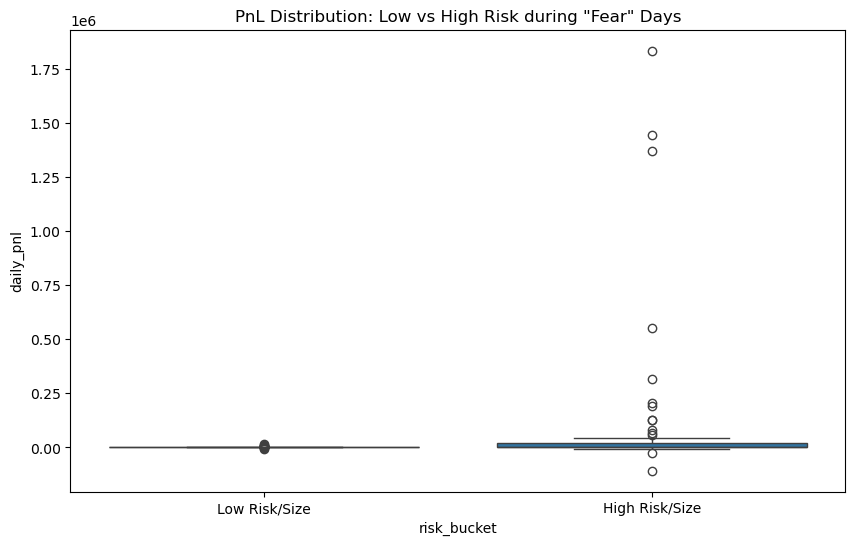

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# Insight 1: The Leverage Trap
Hypothesis: High-risk/size traders underperform during Fear days, showing lower win rates and higher PnL volatility.
    
# Table for Insight 1
insight1_table = daily_trader[daily_trader['classification'] == 'Fear'].groupby('risk_bucket').agg(
    avg_win_rate=('win_rate', 'mean'),
    pnl_volatility=('daily_pnl', 'std'),
    avg_pnl=('daily_pnl', 'mean')
)
print("Insight 1: Risk Impact during Fear\n", insight1_table)

# Boxplot for Insight 1
plt.figure(figsize=(10, 6))
sns.boxplot(data=daily_trader[daily_trader['classification'] == 'Fear'], x='risk_bucket', y='daily_pnl')
plt.title('PnL Distribution: Low vs High Risk during "Fear" Days')
plt.show()


Insight 2: Frequency vs Profit during Greed
                   median_pnl  avg_trades     total_pnl
frequency_bucket                                      
Infrequent          5.303512     8.61194  4.125941e+04
Frequent          670.161504   476.16000  3.148357e+06


C:\Users\Monu\AppData\Local\Temp\ipykernel_4960\2774174398.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  insight2_table = daily_trader[daily_trader['classification'] == 'Greed'].groupby('frequency_bucket').agg(


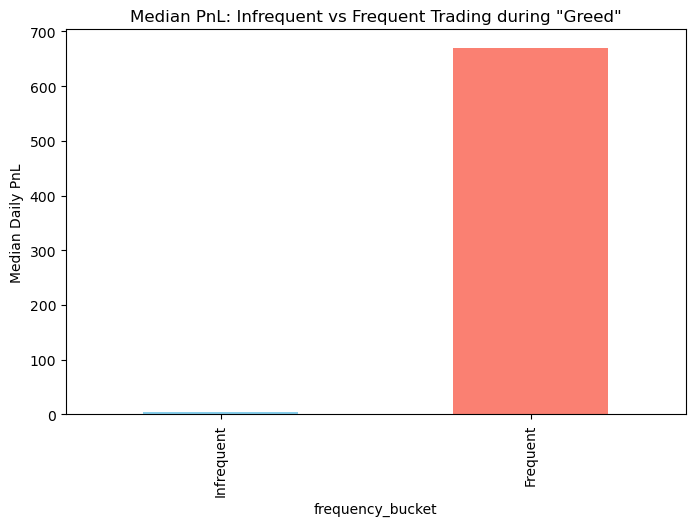

In [36]:
# Table for Insight 2
insight2_table = daily_trader[daily_trader['classification'] == 'Greed'].groupby('frequency_bucket').agg(
    median_pnl=('daily_pnl', 'median'),
    avg_trades=('trades_count', 'mean'),
    total_pnl=('daily_pnl', 'sum')
)
print("\nInsight 2: Frequency vs Profit during Greed\n", insight2_table)

# Bar Chart for Insight 2
insight2_table['median_pnl'].plot(kind='bar', color=['skyblue', 'salmon'], figsize=(8, 5))
plt.title('Median PnL: Infrequent vs Frequent Trading during "Greed"')
plt.ylabel('Median Daily PnL')
plt.show()


Insight 3: Consistency across Sentiments
                    avg_daily_pnl                                           \
classification     Extreme Greed          Fear         Greed      Neutral   
consistency_bucket                                                          
Consistent            307.519697   7773.135218    132.896485   851.606379   
Inconsistent         4083.716614  81144.633445  39767.211916  4239.216532   

                         pnl_std                                              
classification     Extreme Greed           Fear          Greed       Neutral  
consistency_bucket                                                            
Consistent            510.050786   37447.424164     342.916573   6091.133144  
Inconsistent         7649.518183  313726.010930  289025.025537  29086.019197  


C:\Users\Monu\AppData\Local\Temp\ipykernel_4960\92702475.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  insight3_table = daily_trader.groupby(['consistency_bucket', 'classification']).agg(
C:\Users\Monu\AppData\Local\Temp\ipykernel_4960\92702475.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  daily_trader.groupby(['classification', 'consistency_bucket'])['daily_pnl'].mean().unstack().plot(kind='bar', figsize=(12, 6))


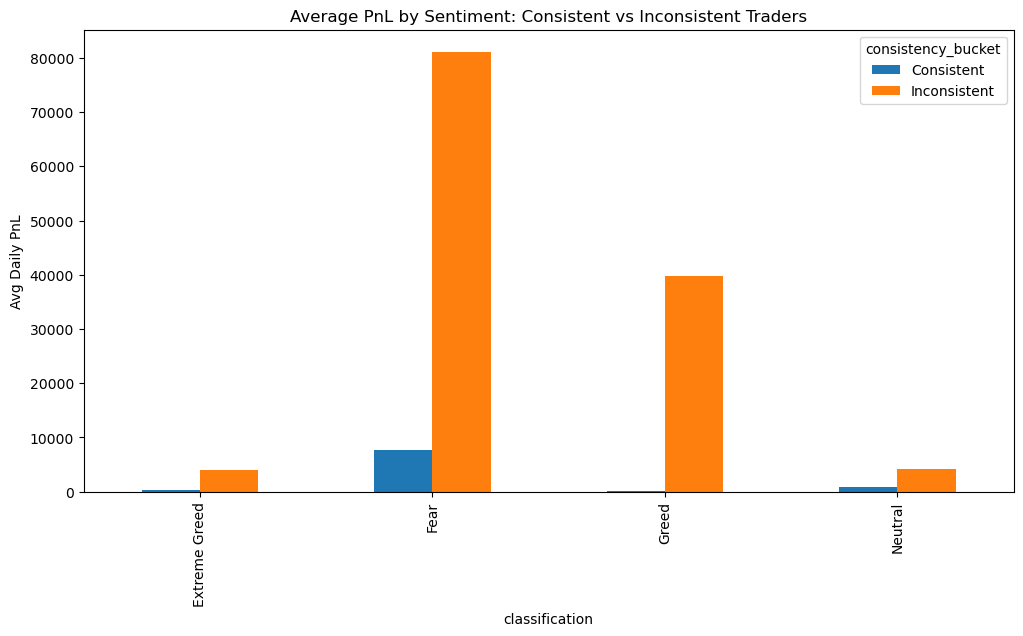

In [37]:
# Insight 3: Discipline vs. Sentiment
Hypothesis: Consistent traders show stable PnL regardless of sentiment, suggesting discipline outweighs market mood.
# Table for Insight 3
insight3_table = daily_trader.groupby(['consistency_bucket', 'classification']).agg(
    avg_daily_pnl=('daily_pnl', 'mean'),
    pnl_std=('daily_pnl', 'std')
).unstack()
print("\nInsight 3: Consistency across Sentiments\n", insight3_table)

# Grouped Bar Chart for Insight 3
daily_trader.groupby(['classification', 'consistency_bucket'])['daily_pnl'].mean().unstack().plot(kind='bar', figsize=(12, 6))
plt.title('Average PnL by Sentiment: Consistent vs Inconsistent Traders')
plt.ylabel('Avg Daily PnL')
plt.show()